In [7]:
# imports
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [16]:
# preparation

# init environments
envs = {
    # "one-agent", "two-agents", "two-agents-mixed", "two-agents-percentage", "three-agents"
    "one-agent": {"agent_amount": 1},
    "two-agents": {"agent_amount": 2},
    "two-agents-mixed": {"agent_amount": 2, "mixed": True},
    "two-agents-percentage": {
        "agent_amount": 2, 
        "percentage":True
    },
    "three-agents": {"agent_amount": 3}
}

# init data logging 
log_data = {}

In [41]:
# read files
df_settings_dict = {}
for setting in envs.keys():
    df_settings_dict[setting] = pd.read_csv('storage/'+setting+'/log.csv')
    # add setting to the df columns
    df_settings_dict[setting].columns = [setting + "_" + str(col) for col in df_settings_dict[setting].columns]

df = pd.concat([df for df in df_settings_dict.values()], axis=1)
# print(df.columns)

# df containing mean rewards per agent and frames 
mean_reward_cols = []
for col in df.columns:
    if "frames" in col:
        last_value = df[col].iloc[-1]
        if not np.isnan(last_value) and "frames" not in mean_reward_cols:
            frames_col = col
            mean_reward_cols.append(col)
    if "mean_reward_agent" in col:
        if "mixed" in col:
            # always add mixed values since they differ from each other
            mean_reward_cols.append(col)
        elif "mean_reward_agent_0" in col:
            # else rewards are the same for all agents so only safe one
            mean_reward_cols.append(col)
df_mean_rewards = df[mean_reward_cols].copy()
# print(df_mean_rewards.columns)
lf_df_mean_rewards = df_mean_rewards.melt(id_vars=[frames_col], var_name="setting", value_name="mean_reward")
lf_df_mean_rewards.rename(columns={frames_col:'frames'}, inplace=True)

# longform_df = d.wide_to_long(df, stubnames='ht', i=['frames', 'reward'], j='age') #df_mean_rewards.transpose().stack().reset_index()
# longform_df_frames = df_frames.transpose().reset_index()
# longform_df_mean_rewards = pd.merge(longform_df, longform_df_frames[frames_col], left_index=True, right_index=True, how='outer')
# print(longform_df_mean_rewards)

<AxesSubplot:xlabel='frames', ylabel='mean_reward'>

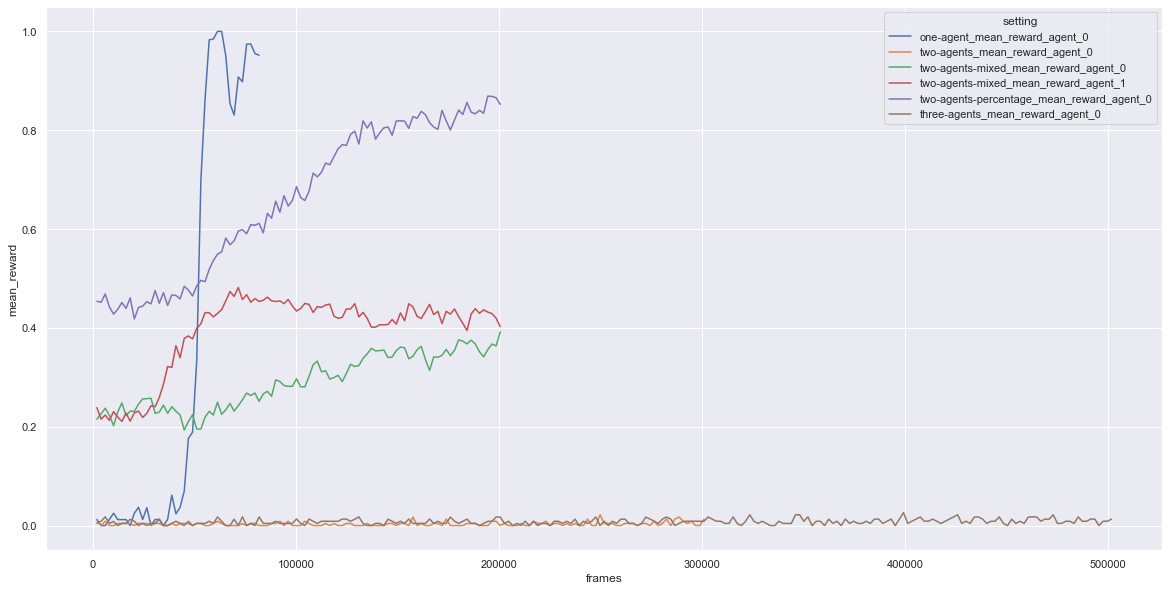

In [47]:
sns.set_theme(style="darkgrid")


plt.figure(figsize=(20,10))
# Plot the responses for different events and regions
sns.lineplot(x="frames", y="mean_reward",
             hue="setting",
             data=lf_df_mean_rewards)